The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Ok, now we have a toy network
Final training loss:  1.1664065746


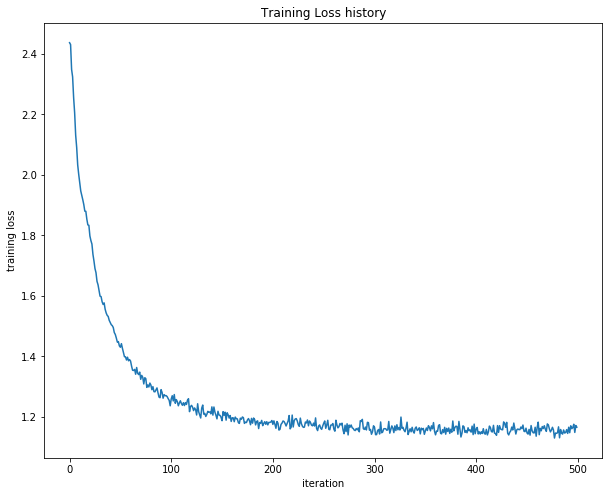

W1 max relative error: 7.730592e-06
W0 max relative error: 4.066723e-06
b1 max relative error: 1.014102e-05
b0 max relative error: 2.784332e-06


In [44]:
# A bit of setup

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

from METU.denoising_autoencoder import DenoisingAutoencoder
from METU.Noise import Noise, GaussianNoise

# Create a small net and some toy data to check your implementations.
# Note that we set the random seed for repeatable experiments.

input_size = 4
hidden_size = 2
num_inputs = 100
# Outputs are equal to the inputs
network_size = (input_size, hidden_size, input_size)

def init_toy_model(num_inputs, input_size):
  np.random.seed(0)
  net = DenoisingAutoencoder((input_size, hidden_size, input_size))
  net.init_weights()
  return net

def init_toy_data(num_inputs, input_size):
  np.random.seed(1)
  X = np.random.randn(num_inputs, input_size)
  return X

net = init_toy_model(num_inputs, input_size)
X = init_toy_data(num_inputs, input_size)
print "Ok, now we have a toy network"

net = init_toy_model(num_inputs, input_size)
reg = 3e-3
stats = net.train_with_SGD(X, noise=GaussianNoise(sd=0.5),
            learning_rate=0.02, learning_rate_decay=0.95, 
            reg=reg, batchsize=100, num_iters=500, verbose=False, activation_function='sigmoid')

print 'Final training loss: ', stats['loss_history'][-1]
# plot the loss history
plt.plot(stats['loss_history'])
plt.xlabel('iteration')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()
from METU.gradient_check import eval_numerical_gradient

reg = 3e-3

# Use numeric gradient checking to check your implementation of the backward pass.
# If your implementation is correct, the difference between the numeric and
# analytic gradients should be less than 1e-8 for each of W1, W2, b1, and b2.

net.init_weights()
noisy_X = GaussianNoise(0.5)(X)
loss, grads = net.loss(noisy_X, X, reg, activation_function='tanh')

# these should all be less than 1e-5 or so
f = lambda W: net.loss(noisy_X, X, reg, activation_function='tanh')[0]
W1_grad = eval_numerical_gradient(f, net.weights[1]['W'], verbose=False)
print '%s max relative error: %e' % ("W1", rel_error(W1_grad, grads[1]['W']))
W0_grad = eval_numerical_gradient(f, net.weights[0]['W'], verbose=False)
print '%s max relative error: %e' % ("W0", rel_error(W0_grad, grads[0]['W']))
b1_grad = eval_numerical_gradient(f, net.weights[1]['b'], verbose=False)
print '%s max relative error: %e' % ("b1", rel_error(b1_grad, grads[1]['b']))
b0_grad = eval_numerical_gradient(f, net.weights[0]['b'], verbose=False)
print '%s max relative error: %e' % ("b0", rel_error(b0_grad, grads[0]['b']))

In [45]:
from cs231n.image_utils import blur_image, deprocess_image, preprocess_image
from cs231n.data_utils import load_CIFAR10
# Modify load_CIFAR10 and the following function to load less data if you have memory issues.
# Load batches 1, 2 and 3; and call the function as follows:
#def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
mean_image = None
def get_CIFAR10_data(num_training=19000, num_validation=1000, num_test=1000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    global mean_image
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
        
    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    
    # Transpose so that channels come first
    X_train = X_train.reshape(X_train.shape[0],-1)
    X_val = X_val.reshape(X_val.shape[0],-1)
    X_test = X_test.reshape(X_test.shape[0],-1)
    #X_train = X_train.transpose(0, 3, 1, 2).copy()
    #X_val = X_val.transpose(0, 3, 1, 2).copy()
    #X_test = X_test.transpose(0, 3, 1, 2).copy()

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape

Train data shape:  (19000, 3072)
Train labels shape:  (19000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3072)
Test labels shape:  (1000,)


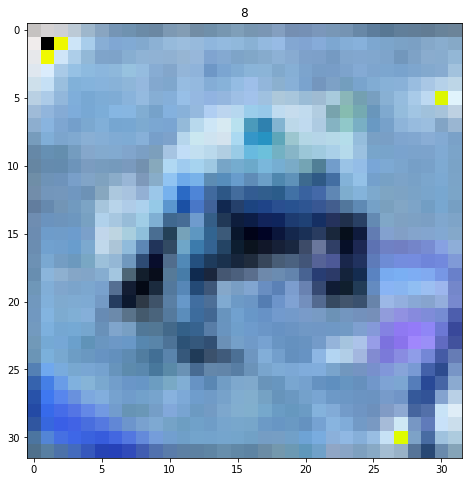

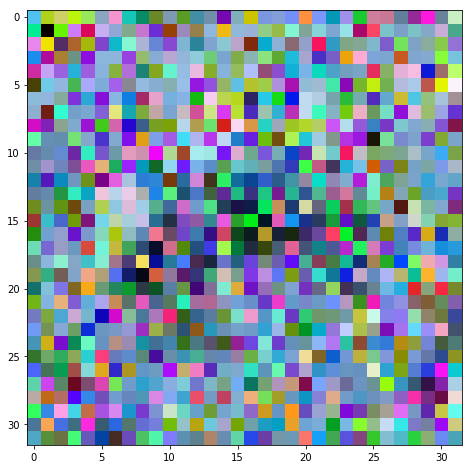

In [46]:
#Visualize some samples
x = X_train[0].reshape(32,32,3)+mean_image#.transpose(1,2,0)#np.reshape(X_train[100], (32,32))

plt.imshow(x)
plt.title(y_train[100])
plt.show()

plt.imshow(GaussianNoise(rate=0.5,sd=0.5)(x))
plt.show()
# Yes, DAE will learn to reconstruct from such corrupted data

In [47]:
import time

input_size = 32 * 32 *3
hidden_size = 300 # Try also sizes bigger than 28*28

reg = 0.003 # 3e-3

net = DenoisingAutoencoder((input_size, hidden_size, input_size))
net.init_weights()

# Train with SGD
tic = time.time()
stats = net.train_with_SGD(X_train, noise=GaussianNoise(rate=0.5,sd=0.5),
            learning_rate=5e-1, learning_rate_decay=0.99, 
            reg=reg, num_iters=1000, batchsize=32, momentum='classic', mu=0.9, verbose=True, 
            activation_function='sigmoid')
toc = time.time()
print toc-tic, 'sec elapsed'

SGD: iteration 0 / 1000: loss 6555710.505248


METU/denoising_autoencoder.py:15: RuntimeWarning: overflow encountered in exp
  return 1./(1+np.exp(-x))


SGD: iteration 10 / 1000: loss 171841019587510749393612156724645462016.000000
SGD: iteration 20 / 1000: loss 462678281668180726475297568806916461438202591631672799489300704592071456783451796884406757652363057960044983633313792.000000
SGD: iteration 30 / 1000: loss 16279730287105803772179212576476372371219920041851753157724043850093964042867658624915141285761372793271417288822619702469132934110989254656.000000
SGD: iteration 40 / 1000: loss 36067865947277548320647070052280494176239400144344856797994898939868102344016085625022393278309781628760693137384781215489863471044662158280466170826333385160991722511495091883264239631088721825483001401180359748304933987488721891022077952.000000
SGD: iteration 50 / 1000: loss 16624107710983710773787286242169710829437814092505350235199875664292237358383225478403276405563100178736564540938513088517650306443394126032928131414087246349475781083346997693974760595758864463822464559484960153851212375068441152065040651645688023425408856476750305858809261488

METU/denoising_autoencoder.py:131: RuntimeWarning: overflow encountered in square
  #############################################################################


SGD: iteration 70 / 1000: loss inf
SGD: iteration 80 / 1000: loss inf
SGD: iteration 90 / 1000: loss inf
SGD: iteration 100 / 1000: loss inf


METU/denoising_autoencoder.py:147: RuntimeWarning: invalid value encountered in multiply
  grads[0]['W'] = X_noisy.T.dot(scores)/X_noisy.shape[0] + reg*W0


SGD: iteration 110 / 1000: loss nan
SGD: iteration 120 / 1000: loss nan
SGD: iteration 130 / 1000: loss nan
SGD: iteration 140 / 1000: loss nan
SGD: iteration 150 / 1000: loss nan


KeyboardInterrupt: 

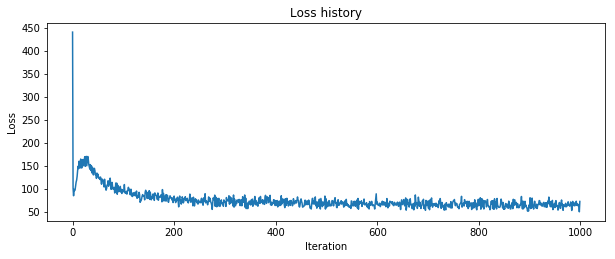

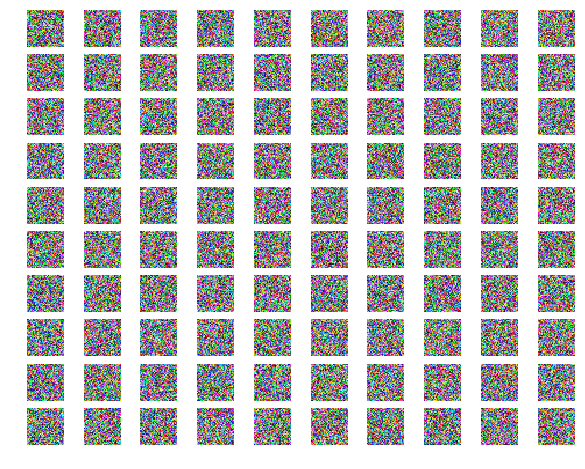

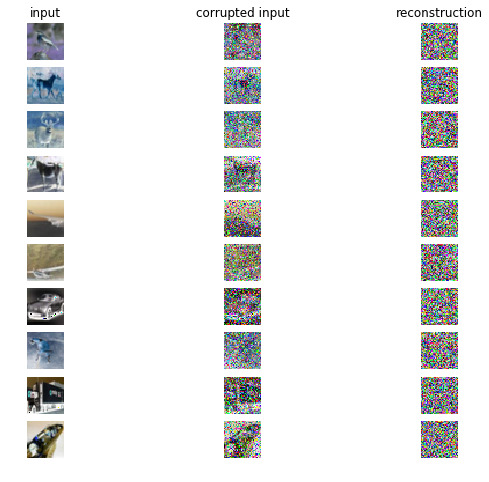

In [41]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.show()
#from cs231n.vis_utils import visualize_grid
#from cs231n.vis_utils import visualize_grid_2D

# SHOW SOME WEIGHTS
W0 = net.weights[0]['W']
W0 = W0.T
num_of_samples=100
for i in range(0,10):
    for j in range(0,10):
        plt.subplot(10, 10, i*10+j+1)
        rand_index = np.random.randint(0,W0.shape[0]-1,1)
        plt.imshow(W0[rand_index].reshape(32,32,3)*256.+mean_image)
        plt.axis('off')
plt.show()
# SHOW SOME RECONSTRUCTIONS
plt_index=1
for i in range(0,10):
    rand_index = np.random.randint(0,X_train.shape[0]-1,1)
    x = X_train[rand_index]
    x_noisy = GaussianNoise(rate=0.5,sd=0.5)(x)
    x_recon = net.predict(x_noisy)
    #x_loss,_ = net.loss(x_noisy, x, reg=0.0, activation_function='sigmoid')
    
    plt.subplot(10,3,plt_index)
    plt.imshow(x.reshape(32,32,3)*256.+mean_image)
    plt.axis('off')
    if i == 0: plt.title('input')
    plt_index+=1
    plt.subplot(10,3,plt_index)
    plt.imshow(x_noisy.reshape(32,32,3)*256.+mean_image)
    plt.axis('off')
    if i == 0: plt.title('corrupted input')
    plt_index+=1
    plt.subplot(10,3,plt_index)
    plt.imshow(x_recon.reshape(32,32,3)*256.+mean_image)
    plt.axis('off')
    if i == 0: plt.title('reconstruction')
    plt_index+=1

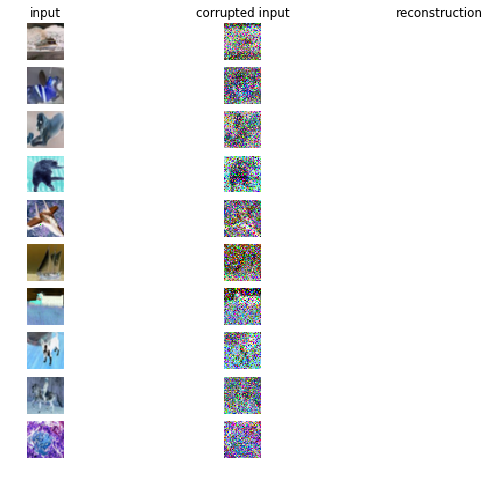